# model

* 이상치 제거 버전
* 이상치 제거하지 않은 버전

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from lightgbm import LGBMRegressor, plot_importance
from sklearn.metrics import roc_auc_score

In [2]:
# knob 종류 및 바운드
knobs_rdb = {
    
    "hash-max-ziplist-entries":     (256, 751), 
    "hash-max-ziplist-value": (16, 257),
    "activerehashing": ('yes', 'no'),  ##yes
    "hz": (1, 41),
    "dynamic-hz": ('yes', 'no'),

    "save0_0": (700,1100),
    "save0_1": (1,9),
    "save1_0": (100,500),
    "save1_1": (10,100),
    "save2_0": (30,90),
    "save2_1": (8000,12000),

    "rdbcompression": ('yes', 'no'), ##yes
    "rdbchecksum": ('yes', 'no'),    ##yes
    "rdb-save-incremental-fsync": ('yes', 'no'),   ## yes

    "activedefrag": ('yes','no'),  
    "active-defrag-threshold-lower": (1, 31),
    "active-defrag-threshold-upper": (70, 101),
    "active-defrag-cycle-min": (1, 31),
    "active-defrag-cycle-max": (70, 91),
    
    "maxmemory": (1000, 2900),   ##"volatile-lru"
    "maxmemory-policy":     ("volatile-lru", "allkeys-lru", "volatile-lfu", "allkeys-lfu", 
                             "volatile-random","allkeys-random", "volatile-ttl", "noeviction"),
    "maxmemory-samples": (3, 7),
    
    "lazyfree-lazy-eviction": ('yes', 'no'),
    "lazyfree-lazy-expire": ('yes', 'no'),
    "lazyfree-lazy-server-del": ('yes', 'no')
}

knobs_list = list(knobs_rdb.keys())
knobs_bound = list(knobs_rdb.values())

## 데이터 전처리
* 이상치 파악
* test, train 데이터 잘 나뉘어졌는지 확인

In [3]:
# config(knob) data
config_df = pd.read_csv("../data/result_config_r10000_rdb.csv", sep=',')

# 1250 개 추출
config_df = config_df.iloc[0:1250,:]
config_df.shape

# external(throughput) data
# external_df = pd.read_csv("./data/external_metrics0.csv", sep=',')
external_df = pd.read_csv("../data/external_metrics_r10000_rdb2.csv", sep=',')
# 1250 개 추출
external_df = external_df.iloc[0:1250,:]
external_df.shape

(1250, 32)

In [4]:
config_df.head(3)

,appendonly,appendfsync,auto-aof-rewrite-percentage,auto-aof-rewrite-min-size,no-appendfsync-on-rewrite,aof-rewrite-incremental-fsync,aof-use-rdb-preamble,save0_0,save0_1,save1_0,...,maxmemory-policy,maxmemory-samples,lazyfree-lazy-eviction,lazyfree-lazy-expire,lazyfree-lazy-server-del,hash-max-ziplist-entries,hash-max-ziplist-value,activerehashing,hz,dynamic-hz
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1056,4,114,...,volatile-lru,6,yes,no,no,615,232,no,23,no
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,805,2,343,...,allkeys-lru,7,yes,no,no,496,156,yes,36,no
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,776,6,194,...,volatile-random,5,no,yes,no,494,135,no,37,no


In [5]:
# config(knog), external(throughput) 데이터 하나의 프레임으로 결합
dataset = config_df
dataset['throughput'] = external_df['Gets_KB/sec']

In [6]:
# 결측치 처리 
dataset_nan = dataset.copy()
dataset['activedefrag'].fillna(value='no', inplace=True)  # activedefrag no 채우기
dataset = dataset.fillna(value = 0)  # 전부 0으로 채움

In [7]:
dataset.head(3)

,appendonly,appendfsync,auto-aof-rewrite-percentage,auto-aof-rewrite-min-size,no-appendfsync-on-rewrite,aof-rewrite-incremental-fsync,aof-use-rdb-preamble,save0_0,save0_1,save1_0,...,maxmemory-samples,lazyfree-lazy-eviction,lazyfree-lazy-expire,lazyfree-lazy-server-del,hash-max-ziplist-entries,hash-max-ziplist-value,activerehashing,hz,dynamic-hz,throughput
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1056,4,114,...,6,yes,no,no,615,232,no,23,no,54215.82
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,805,2,343,...,7,yes,no,no,496,156,yes,36,no,62668.81
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,776,6,194,...,5,no,yes,no,494,135,no,37,no,62733.49


In [8]:
# maxmemory knob 단위(mb) 처리
dataset['maxmemory']  = dataset['maxmemory'].str.strip('mb')
dataset['maxmemory'] = pd.to_numeric(dataset['maxmemory'])

In [9]:
# Object 변수 categorical 로 변경 (LightGBM에 바로 넣기 위해)
category_knob = []

for knob in dataset:
    if dataset[knob].dtype == 'O':  # Object인 경우 category 형으로 변경
        dataset[knob] = dataset[knob].astype('category')
        if knob in knobs_list:
            category_knob.append(knob)

In [10]:
# 설정한 knob들만 추출
extract_knobs_list = knobs_list.copy()
extract_knobs_list.append('throughput')  # target 값 추가

dataset = dataset[extract_knobs_list]

In [11]:
# numeric_knob
numeric_knob = []

for knob in dataset:
    if dataset[knob].dtype == 'category':  # Object인 경우 category 형으로 변경
        continue
    numeric_knob.append(knob)

numeric_knob.remove('throughput')

In [12]:
dataset.head(3)

,hash-max-ziplist-entries,hash-max-ziplist-value,activerehashing,hz,dynamic-hz,save0_0,save0_1,save1_0,save1_1,save2_0,...,active-defrag-threshold-upper,active-defrag-cycle-min,active-defrag-cycle-max,maxmemory,maxmemory-policy,maxmemory-samples,lazyfree-lazy-eviction,lazyfree-lazy-expire,lazyfree-lazy-server-del,throughput
0,615,232,no,23,no,1056,4,114,13,57,...,0.0,0.0,0.0,2000,volatile-lru,6,yes,no,no,54215.82
1,496,156,yes,36,no,805,2,343,23,47,...,0.0,0.0,0.0,1200,allkeys-lru,7,yes,no,no,62668.81
2,494,135,no,37,no,776,6,194,46,61,...,77.0,2.0,71.0,1800,volatile-random,5,no,yes,no,62733.49


In [13]:
# 결측치 처리전 확인
print(dataset_nan.info())

# 결측치 처리후 확인
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   appendonly                     0 non-null      float64
 1   appendfsync                    0 non-null      float64
 2   auto-aof-rewrite-percentage    0 non-null      float64
 3   auto-aof-rewrite-min-size      0 non-null      float64
 4   no-appendfsync-on-rewrite      0 non-null      float64
 5   aof-rewrite-incremental-fsync  0 non-null      float64
 6   aof-use-rdb-preamble           0 non-null      float64
 7   save0_0                        1250 non-null   int64  
 8   save0_1                        1250 non-null   int64  
 9   save1_0                        1250 non-null   int64  
 10  save1_1                        1250 non-null   int64  
 11  save2_0                        1250 non-null   int64  
 12  save2_1                        1250 non-null   i

### 이상치 처리

In [14]:
# # 이상치 인덱스 반환 함수
# def get_outlier(df=None, column=None, weight=1.5):
    
#     # target 값과 상관관계가 높은 열을 우선적으로 진행
#     quantile_25 = np.percentile(df[column].values, 25)
#     quantile_75 = np.percentile(df[column].values, 75)

#     IQR = quantile_75 - quantile_25
#     IQR_weight = IQR*weight

#     lowest = quantile_25 - IQR_weight
#     highest = quantile_75 + IQR_weight

#     outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
#     return outlier_idx

In [15]:
# import seaborn as sns
# sns.boxplot(dataset['throughput'])

In [16]:
# outlier_index = get_outlier(dataset, 'throughput')

# # 이상치 제거
# dataset.drop(outlier_index, axis=0, inplace = True)
# sns.boxplot(dataset['throughput'])

In [17]:
# 타입 확인 (카테고리)
dataset.dtypes

hash-max-ziplist-entries            int64
hash-max-ziplist-value              int64
activerehashing                  category
hz                                  int64
dynamic-hz                       category
save0_0                             int64
save0_1                             int64
save1_0                             int64
save1_1                             int64
save2_0                             int64
save2_1                             int64
rdbcompression                   category
rdbchecksum                      category
rdb-save-incremental-fsync       category
activedefrag                     category
active-defrag-threshold-lower     float64
active-defrag-threshold-upper     float64
active-defrag-cycle-min           float64
active-defrag-cycle-max           float64
maxmemory                           int64
maxmemory-policy                 category
maxmemory-samples                   int64
lazyfree-lazy-eviction           category
lazyfree-lazy-expire             c

### test, train 데이터 분리

In [18]:
#  정확도 확인용 train 8, test 2
X_train_val, X_test, y_train_val, y_test = train_test_split(dataset.iloc[:,:-1]
                                                    , dataset['throughput'] 
                                                    ,test_size=0.2
                                                   , random_state = 156)

# train 8 val 2
X_train, X_val, y_train, y_val = train_test_split(X_train_val
                                                    , y_train_val 
                                                    ,test_size=0.2
                                                   , random_state = 156)


# # 전체 데이터 train 8, val 2
# X_train, X_val, y_train, y_val = train_test_split(dataset.iloc[:,:-1]
#                                                     , dataset['throughput'] 
#                                                     ,test_size=0.2
#                                                    , random_state = 156)


In [19]:
# # scaling
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(X_train[numeric_knob])  # x_train 스케일 기준 정보 적용

# X_train_index = list(X_train.index)  # X_train 인덱스
# X_train_scaled_numeric = scaler.transform(X_train[numeric_knob])  # transformation
# X_train_scaled_numeric_df = pd.DataFrame(X_train_scaled_numeric, columns = numeric_knob, index = X_train_index)  
# X_train_scaled_df = pd.concat([X_train_scaled_numeric_df, X_train[category_knob]], axis=1)  # 카테고리와 합치기

# X_val_index = list(X_val.index)  # X_val 인덱스
# X_val_scaled_numeric = scaler.transform(X_val[numeric_knob])  # transformation
# X_val_scaled_numeric_df = pd.DataFrame(X_val_scaled_numeric, columns = numeric_knob, index = X_val_index)  
# X_val_scaled_df = pd.concat([X_val_scaled_numeric_df, X_val[category_knob]], axis=1)  # 카테고리와 합치기


# # X_test_index = list(X_test.index)  # X_train 인덱스
# # X_test_scaled_numeric = scaler.transform(X_test[numeric_knob])  # transformation
# # X_test_scaled_numeric_df = pd.DataFrame(X_test_scaled_numeric, columns = numeric_knob, index = X_test_index)  
# # X_test_scaled_df = pd.concat([X_test_scaled_numeric_df, X_test[category_knob]], axis=1)  # 카테고리와 합치기


In [20]:

# # test, train 에 비슷하게 분류됬는지 확인
# y_train.hist()
# plt.title('train data')
# plt.show()

# y_test.hist()
# plt.title('test data')
# plt.show()

## LightGBM 모델 생성

In [22]:
# 모델 객체 생성, n_estimators = 400으로 설정
lgbm_wrapper = LGBMRegressor(n_estimators=1000, learning_rate=0.1)

# 검증 데이터(validation data)
evals = [(X_val, y_val)]

lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc',
                eval_set = evals, verbose = True, categorical_feature=category_knob)


[1]	valid_0's auc: 1	valid_0's l2: 2.3746e+07
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 1	valid_0's l2: 2.37842e+07
[3]	valid_0's auc: 1	valid_0's l2: 2.38581e+07
[4]	valid_0's auc: 1	valid_0's l2: 2.4134e+07
[5]	valid_0's auc: 1	valid_0's l2: 2.43777e+07
[6]	valid_0's auc: 1	valid_0's l2: 2.44166e+07
[7]	valid_0's auc: 1	valid_0's l2: 2.43715e+07
[8]	valid_0's auc: 1	valid_0's l2: 2.44943e+07
[9]	valid_0's auc: 1	valid_0's l2: 2.4586e+07
[10]	valid_0's auc: 1	valid_0's l2: 2.45064e+07
[11]	valid_0's auc: 1	valid_0's l2: 2.44866e+07
[12]	valid_0's auc: 1	valid_0's l2: 2.46928e+07
[13]	valid_0's auc: 1	valid_0's l2: 2.48098e+07
[14]	valid_0's auc: 1	valid_0's l2: 2.48075e+07
[15]	valid_0's auc: 1	valid_0's l2: 2.50661e+07
[16]	valid_0's auc: 1	valid_0's l2: 2.50603e+07
[17]	valid_0's auc: 1	valid_0's l2: 2.52293e+07
[18]	valid_0's auc: 1	valid_0's l2: 2.53089e+07
[19]	valid_0's auc: 1	valid_0's l2: 2.53167e+07
[20]	valid_0's auc: 1	valid_0's l2: 2.

LGBMRegressor(n_estimators=1000)

## 성능 평가

In [24]:
# 성능 측정 함수 RMSLE(캐글에서 요구한 성능 평가 방법), MSE, RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
# log 값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산 
def rmsle(y, pred):
    # log1p 변환
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    
    # squred 계산
    squared_error = (log_y-log_pred)**2
    
    # RMSE 계산
    rmsle = np.sqrt(np.mean(squared_error))
    
    return rmsle

# 사이킷런의 mean_square_error()를 이용해 RMSE 계산
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

# MSE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    
    # MAE는 사이킷런의 mean_absolute_error()로 계산
    mae_val = mean_absolute_error(y, pred)
    
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))
    

In [25]:
# preds = lgbm_wrapper.predict(X_test_scaled_df)  # 예측 결과
# evaluate_regr(y_test, preds)

In [26]:
# lgbm_wrapper.predict(X_test.iloc[3:4,:])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

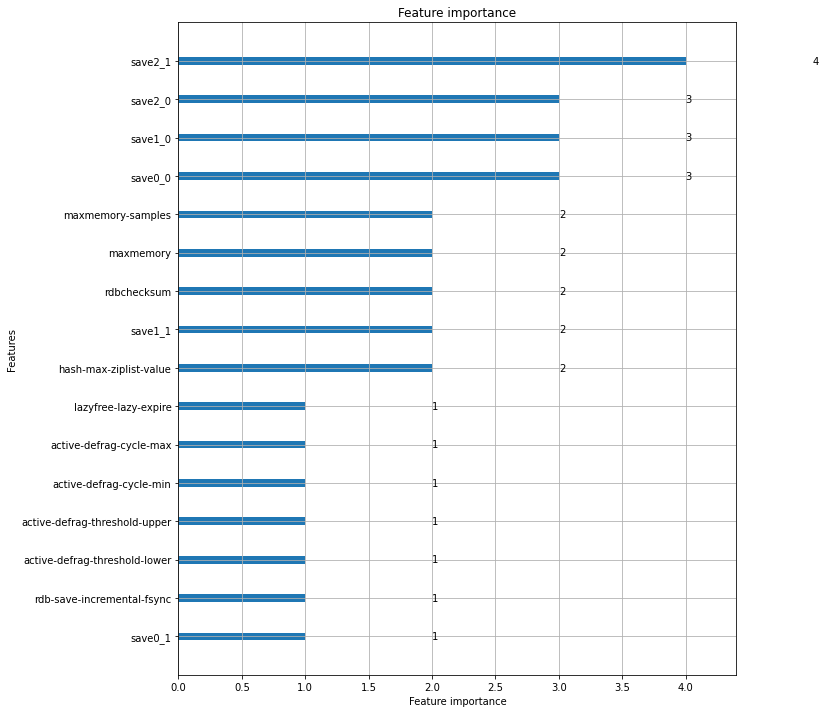

In [27]:
# plot_importance()를 이영해 피처 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax= ax)

In [28]:
# 디폴트 값 넣어보기
default_val = {

    'hash-max-ziplist-entries': [512],
    'hash-max-ziplist-value': [64],
    'activerehashing': ['yes'],
    'hz': [10],
    'dynamic-hz': ['yes'],
    'save0_0': [900],
    'save0_1':[1],
    'save1_0': [300],
    'save1_1':[10],
    'save2_0': [60],
    'save2_1':[10000],
    'rdbcompression': ['yes'],
    'rdbchecksum': ['yes'],
    'rdb-save-incremental-fsync': ['yes'],
    'activedefrag': ['yes'],
    'active-defrag-threshold-lower': [10],
    'active-defrag-threshold-upper': [100],
    'active-defrag-cycle-min': [5],
    'active-defrag-cycle-max': [75],
    'maxmemory': [0],
    'maxmemory-policy':['noeviction'],
    'maxmemory-samples': [5],
    'lazyfree-lazy-eviction': ['no'],
    'lazyfree-lazy-expire': ['no'],
    'lazyfree-lazy-server-del': ['no']

}

default_df = pd.DataFrame(default_val)
        

for knob in default_df:
    if default_df[knob].dtype == 'O':  # Object인 경우 category 형으로 변경
        default_df[knob] = default_df[knob].astype('category')


In [29]:
lgbm_wrapper.predict(default_df)

array([58315.15458374])

---

### 하이퍼파라미터 튜닝

In [30]:
# from sklearn.model_selection import GridSearchCV

# # 하이퍼파라미터 튜닝시 수행 속도를 향상시키기 위해 n_estimators를 200으로 감소
# lgbm_wrapper = LGBMRegressor(n_estimators = 200)

# params = {
#     'num_leaves':[32, 64],
#     'max_depth':[128, 160],
#     'min_child_samples':[60, 100],
#     'subsample':[0.8, 1]
# }

# # cv는 3으로 가정 (교차 검증을 자동으로 해주는건가?)
# gridcv = GridSearchCV(lgbm_wrapper, param_grid = params, cv=3)
# gridcv.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric='auc', 
#           eval_set = [(X_train, y_train), (X_test, y_test)])

# print('GridSeaerchCV 최적 파라미터:', gridcv.best_params_)

In [31]:
# # 하이퍼 파라미터 적용 후 다시 생성
# lgbm_wrapper = LGBMRegressor(n_estimators = 1000,
#                             num_leaves = 32,
#                             subsample=0.8,
#                             min_child_samples=60,
#                             max_depth=128)

# evals = [(X_test, y_test)]

# lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100,
#                 eval_metric='auc',
#                 eval_set=evals,
#                 verbose=True)

---

# BO

In [32]:
def knob_to_dict(knob_dict):
    for key, val in knob_dict.items():
                
        if 'yes' in key:
            if val == 0:
                continue
            elif val == 1:
                print(key[:-4], end=' ')
                print('yes')
                continue
        elif 'no' in key:
            if val == 0:
                continue
            elif val == 1:
                print(key[:-3], end=' ')
                print('no')
                continue        
        
        if 'save' in key:
            if key[6] == '0':
                print('save', end=' ')
                print(val, end=' ')
            elif key[6] == '1':
                print(val)
            continue
        
        if 'maxmemory' in key:
            if 'policy' in key:
                if val == 1:
                    print('maxmemory-policy', end=' ')
                    print(key[17:])
                    continue
                
                elif val == 0:
                    continue
            
            elif len(key) == 9:
                print(key, end=' ')
                print(val, end='')
                print('mb')
                continue                        
                
        print(key, end=' ')
        print(val)

def knob_to_dict2(knob_dict):
    for key, val in knob_dict.items():
                        
        if 'save' in key:
            if key == 'rdb-save-incremental-fsync':
                print(key, end=' ')
                print(val)
                continue
            
            if key[6] == '0':
                print('save', end=' ')
                print(val, end=' ')
            elif key[6] == '1':
                print(val)
            continue
        
        if key == 'maxmemory':
            print(key, end=' ')
            print(val,end='')
            print('mb')
            continue
                        
        print(key, end=' ')
        print(val)


## 목적함수

In [33]:
noise_level = 0.1

def objective_func(knob_value, noise_level=noise_level):

    knob_dict = {}
    for knob in knobs_list: # 순서에 맞게 선언
        knob_dict[knob] = 'x'
    
#     print('###x 삽입###')
#     print(knob_dict)
    
    # knob_value 값 먼저 할당
    for idx,knob in enumerate(knobs):
        knob_dict[knob] = knob_value[idx]
    
#     print('##먼저할당##')
#     print(knob_dict)
    
    
    # 나머지 값 채우기 
    for knob ,knob_val in knob_dict.items():
        if knob_val == 'x':
            knob_dict[knob] = knobs_update[knob]
            
#     print('##나머지 update 반영 할당##')
#     print(knob_dict)
                    
    if 'activedefrag' in knob_dict:
        if knob_dict['activedefrag'] == 'no':  # activedefrag no인 경우 나머지 관련 knob들에 0할당!
            activ_var = ['active-defrag-threshold-lower', 'active-defrag-threshold-upper', 'active-defrag-cycle-min', 'active-defrag-cycle-max']
            for activ_knob in activ_var:
                knob_dict[activ_knob] = 0     
    
    knob_df = pd.DataFrame(knob_dict, index=[0])  # 데이터 프레임으로 변환
#     print(knob_df)
    
    # 카테고리 변수 변경
    for knob in category_knob:
        knob_df[knob] = knob_df[knob].astype('category') 
    
    
    return -lgbm_wrapper.predict(knob_df)[0]


## gp_minimize

In [34]:
%matplotlib inline
print(__doc__)

import numpy as np
np.random.seed(237)
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process
from skopt import gp_minimize

Automatically created module for IPython interactive environment


In [44]:
cluster_table = {

    'clsuter0':[        
        
        "rdbcompression",
        "lazyfree-lazy-eviction",
        'lazyfree-lazy-expire',
        "dynamic-hz",
        "hash-max-ziplist-value",
        
    ],
    'cluster1':[
        'active-defrag-threshold-lower',
        'active-defrag-threshold-upper', 
        'active-defrag-cycle-min',
        'active-defrag-cycle-max',
        'rdbchecksum',
        'rdb-save-incremental-fsync', 
        'lazyfree-lazy-server-del', 
        'activerehashing', 
        'save0_0',
        'save0_1', 
        'save1_0', 
        "save1_1", 
        'save2_0', 
        "save2_1", 
        'maxmemory', 
        'maxmemory-samples' ,
        'hash-max-ziplist-entries',
        'hz', 
     ]

}

knobs_update = {

    'hash-max-ziplist-entries': 512,
    'hash-max-ziplist-value': 64,
    'activerehashing': 'yes',
    'hz': 10,
    'dynamic-hz': 'yes',
    'save0_0': 900,
    'save0_1':1,
    'save1_0': 300,
    'save1_1':10,
    'save2_0': 60,
    'save2_1':10000,
    'rdbcompression': 'yes',
    'rdbchecksum': 'yes',
    'rdb-save-incremental-fsync': 'yes',
    'activedefrag': 'yes',
    'active-defrag-threshold-lower': 10,
    'active-defrag-threshold-upper': 100,
    'active-defrag-cycle-min': 5,
    'active-defrag-cycle-max': 75,
    'maxmemory': 0,
    'maxmemory-policy':'noeviction',
    'maxmemory-samples': 5,
    'lazyfree-lazy-eviction': 'no',
    'lazyfree-lazy-expire': 'no',
    'lazyfree-lazy-server-del': 'no'

}


In [45]:
res_result = []
knob_update_list = []

for i in range(1):
    print('###########{}##########'.format(i))
    
    iter_per_res = 0
    
    for cluster, knobs in cluster_table.items():
        print('#####{}#####'.format(cluster))
        gp_knobs_bound = []

        # 1. 클러스터의 bound 생성
#         print('{} bound 생성'.format(cluster))
        for knob in knobs: 
            gp_knobs_bound.append(knobs_rdb[knob])

#         print('{} gp 진행'.format(cluster))
        # 2. gp_minimize 진행
        res = gp_minimize(

                    objective_func,                  # 목적함수
                    gp_knobs_bound,      # bound
                    random_state=np.random.randint(1,1234),
            
                    acq_func="EI",      
                    n_calls=20,      # 총 반복 횟수
                    n_random_starts=5,    # 초기 랜덤 값
                    noise=0.1**2,       
        )   

        # 결과 knob 값들
#         print('{} gp 완료'.format(cluster))
        res_result.append(res)
        gp_result = res.x
        iter_per_res = res.fun
                
        for idx,knob in enumerate(knobs):
            knobs_update[knob] = gp_result[idx]
        
        knob_update_list.append(knobs_update.copy())
        
        print('{}-th'.format(i))
        print(res.func_vals)
        print(res.fun)
        
    print(iter_per_res)
    print()
        


###########0##########
#####clsuter0#####
0-th
[-58711.54789493 -58315.15458374 -58315.15458374 -58315.15458374
 -58315.15458374 -58711.54789493 -58315.15458374 -58315.15458374
 -58315.15458374 -58711.54789493 -58711.54789493 -58711.54789493
 -58711.54789493 -58711.54789493 -58711.54789493 -58711.54789493
 -58711.54789493 -58711.54789493 -58711.54789493 -58711.54789493]
-58711.54789493268
#####cluster1#####
0-th
[-58323.69841814 -58932.52553119 -59019.36994034 -58711.54789493
 -58384.83438615 -58606.53842679 -58377.71864009 -58785.66059563
 -58384.83438615 -58501.86613159 -58711.54789493 -58785.66059563
 -58384.83438615 -58501.86613159 -58948.75399323 -58323.69841814
 -58323.69841814 -59135.00581074 -59135.00581074 -58932.52553119]
-59135.00581073761
-59135.00581073761



* 예측값: 59135.00581073761
* 예측조합
hash-max-ziplist-entries 473
hash-max-ziplist-value 214
activerehashing no
hz 34
dynamic-hz no
save 715 7
save 499 100
save 89 10611
rdbcompression yes
rdbchecksum no
activedefrag yes
active-defrag-threshold-lower 7
active-defrag-threshold-upper 89
active-defrag-cycle-min 10
active-defrag-cycle-max 73
maxmemory 2200mb
maxmemory-policy noeviction
maxmemory-samples 5
lazyfree-lazy-eviction yes
lazyfree-lazy-expire yes
lazyfree-lazy-server-del yes

In [46]:
# update 조합 
knob_to_dict(knob_update_list[1])

hash-max-ziplist-entries 473
hash-max-ziplist-value 214
activerehashing no
hz 34
dynamic-hz no
save 715 7
save 499 100
save 89 10611
rdbcompression yes
rdbchecksum no
activedefrag yes
active-defrag-threshold-lower 7
active-defrag-threshold-upper 89
active-defrag-cycle-min 10
active-defrag-cycle-max 73
maxmemory 2200mb
maxmemory-policy noeviction
maxmemory-samples 5
lazyfree-lazy-eviction yes
lazyfree-lazy-expire yes
lazyfree-lazy-server-del yes


### 전체 knob 대상( 60440.76670625305 )

In [47]:
# 전체 데이터 대상
res_result_T = []

cluster_table_T = {

    'clsuter1':
    [
                'save0_0',
        'save0_1', 
        'save1_1',
        'maxmemory-samples',
        'hash-max-ziplist-value',
        
        'rdbcompression',
        'lazyfree-lazy-expire',
        'lazyfree-lazy-server-del',
        
        'dynamic-hz',
        'activerehashing',
                'active-defrag-cycle-min',
        'active-defrag-cycle-max',
        'active-defrag-threshold-lower',
        'active-defrag-threshold-upper',
        
        'save1_0', 
        'save2_0',
        'save2_1',
        'maxmemory',
        'hash-max-ziplist-entries',
        'hz',
 
        'rdbchecksum',
        'rdb-save-incremental-fsync',
        'lazyfree-lazy-eviction',
        
        'activedefrag',
        'maxmemory-policy'
       
               ]
}

knobs_update = {

    'hash-max-ziplist-entries': 'x',
    'hash-max-ziplist-value': 'x',
    'activerehashing': 'x',
    'hz': 'x',
    'dynamic-hz': 'x',
    'save0_0': 'x',
    'save0_1':'x',
    'save1_0': 'x',
    'save1_1':'x',
    'save2_0': 'x',
    'save2_1':'x',
    'rdbcompression': 'x',
    'rdbchecksum': 'x',
    'rdb-save-incremental-fsync': 'x',
    'activedefrag': 'x',
    'active-defrag-threshold-lower': 'x',
    'active-defrag-threshold-upper': 'x',
    'active-defrag-cycle-min': 'x',
    'active-defrag-cycle-max': 'x',
    'maxmemory': 'x',
    'maxmemory-policy':'x',
    'maxmemory-samples': 'x',
    'lazyfree-lazy-eviction': 'x',
    'lazyfree-lazy-expire': 'x',
    'lazyfree-lazy-server-del': 'x'

}


for i in range(1):
    print('###########{}##########'.format(i))
    
    iter_per_res = 0
    
    for cluster, knobs in cluster_table_T.items():
        print('#####{}#####'.format(cluster))
        gp_knobs_bound = []

        # 1. 클러스터의 bound 생성
#         print('{} bound 생성'.format(cluster))
        for knob in knobs: 
            gp_knobs_bound.append(knobs_rdb[knob])

#         print('{} gp 진행'.format(cluster))
        # 2. gp_minimize 진행
        res = gp_minimize(

                    objective_func,                  # 목적함수
                    gp_knobs_bound,      # bound
                    random_state=np.random.randint(1,1234),
#                     x0 = x0_list,
#                     y0 = y0_val, 
            
                    acq_func="EI",      
                    n_calls=30,      # 총 반복 횟수
                    n_random_starts=5,    # 초기 랜덤 값
                    noise=0.1**2,       
        )   

        # 결과 knob 값들
#         print('{} gp 완료'.format(cluster))
        gp_result = res.x
        iter_per_res = res.fun
        res_result_T.append(res)
        
        for idx,knob in enumerate(knobs):
            knobs_update[knob] = gp_result[idx]
        
        print('{}-th'.format(i))
        print(res.func_vals)
        print(res.fun)
        
    print(iter_per_res)
    print()
        


###########0##########
#####clsuter1#####
0-th
[-59135.00581074 -58377.71864009 -58323.69841814 -58617.75461363
 -58548.39876321 -58769.05237956 -59019.36994034 -59076.76782054
 -58377.71864009 -58692.34059082 -58734.02517695 -59076.76782054
 -59076.76782054 -59135.00581074 -58711.54789493 -59019.36994034
 -58606.53842679 -58401.43776634 -59006.46434457 -58711.54789493
 -58384.83438615 -58944.4425065  -58692.34059082 -59135.00581074
 -59135.00581074 -59076.76782054 -58548.39876321 -58932.52553119
 -58650.88082886 -58734.02517695]
-59135.00581073761
-59135.00581073761



* 예측값 : 59135.00581073761

* 예측 조합
hash-max-ziplist-entries 473
hash-max-ziplist-value 139
activerehashing yes
hz 39
dynamic-hz yes
save 846 3
save 393 86
save 58 11520
rdbcompression yes
rdbchecksum yes
rdb-save-incremental-fsync no
activedefrag yes
active-defrag-threshold-lower 16
active-defrag-threshold-upper 88
active-defrag-cycle-min 3
active-defrag-cycle-max 73
maxmemory 2347mb
maxmemory-policy allkeys-random
maxmemory-samples 5
lazyfree-lazy-eviction yes
lazyfree-lazy-expire no
lazyfree-lazy-server-del yes

In [48]:
knob_to_dict2(knobs_update)

hash-max-ziplist-entries 473
hash-max-ziplist-value 139
activerehashing yes
hz 39
dynamic-hz yes
save 846 3
save 393 86
save 58 11520
rdbcompression yes
rdbchecksum yes
rdb-save-incremental-fsync no
activedefrag yes
active-defrag-threshold-lower 16
active-defrag-threshold-upper 88
active-defrag-cycle-min 3
active-defrag-cycle-max 73
maxmemory 2347mb
maxmemory-policy allkeys-random
maxmemory-samples 5
lazyfree-lazy-eviction yes
lazyfree-lazy-expire no
lazyfree-lazy-server-del yes


---